# Part 3: Practical Application of Fairness Metrics

In this notebook section, we apply the fairness metrics you've learned about to a real-world scenario. The goal is to:

- Train a predictive model
- Evaluate its statistical and fairness-related performance
- Apply fairness interventions
- Reflect on trade-offs and challenges in fair machine learning

We use a dataset on student outcomes to predict whether a student will graduate or drop out. A university could use this information and focus on supporting students that are predicted to drop out.

> The potential benefit of such an application is clear - but it also raises ethical concerns:
>
> - If the model **wrongly predicts graduation**, a student in need may receive **no support**.
> - If the model **wrongly predicts dropout**, a student may receive **unnecessary intervention**.
>
> It is essential to consider **which kinds of errors matter more**, and **for whom**.
> In this case, missing a student who is about to drop out (false negative) may be **more harmful** than offering unnecessary support (false positive).

We will explore how fairness metrics behave in this context and see why **no single metric** is sufficient to assess fairness.

The dataset used in this study is the Student Performance Dataset from the UCI Machine Learning Repository. It contains information about students enrolled in higher education institutions in Portugal. The dataset includes dempgraphic data (e.g. gender, age, marital status), academic performance (e.g. grades, failures), and institutional factors (e.g. scholarship status, application preferences).<sup>1</sup>

---

First we **import** the necessary libraries. Use pip install for packages you do not have.

---

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import confusion_matrix, accuracy_score
from fairlearn.postprocessing import ThresholdOptimizer

---

### Load data

Next we load the dataset. **Adjust the path** to where you saved the data. Nationality is removed, because it is strongly imbalanced (most students are from Portugal), providing little analytical value and potentially introducing unwanted bias. To have a binary classification task we only keep `Graduate` and `Dropout` as target variables. 

---

In [2]:
# Load dataset
df = pd.read_csv(r'C:\Users\lukas\Desktop\Fairness_Notebook\Data\Student_Study\student_data.csv', sep=';') # Adjust to your path
df = df[df['Target'] != 'Enrolled'] # Keep only Graduate and Dropout
df['Target'] = df['Target'].map({'Graduate': 1, 'Dropout': 0}) # Binary mapping
df = df.drop(columns=['Nacionality']) # Drop imbalanced feature

---

### Explore the data

Let's start by examining the distribution of our target variable (`Graduate` vs `Dropout`) and how it differs across gender.

---

Target
Graduate    0.60854
Dropout     0.39146
Name: proportion, dtype: float64

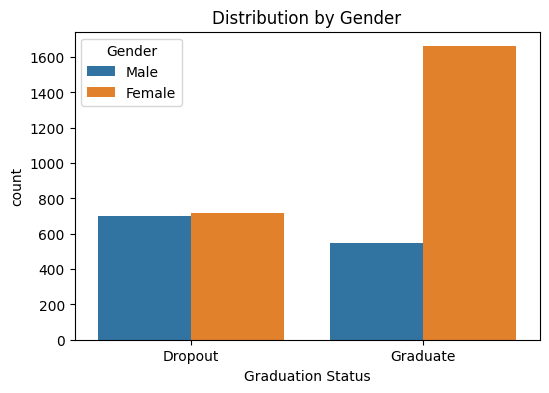

Target,Dropout,Graduate
Gender,,
Female,720,1661
Male,701,548


In [3]:
# Create copy for vizualization
df_plot = df.copy()
df_plot['Target'] = df_plot['Target'].map({1: 'Graduate', 0: 'Dropout'}) # Mapping to names again
df_plot['Gender'] = df_plot['Gender'].map({1: 'Male', 0: 'Female'})

# Visualization
display(df_plot['Target'].value_counts(normalize=True)) # Display percentage
plt.figure(figsize=(6,4))
sns.countplot(data=df_plot, x='Target', hue='Gender')
plt.title('Distribution by Gender')
plt.xlabel('Graduation Status')
plt.show()

# Cross-table 
counts = pd.crosstab(df_plot['Gender'], df_plot['Target'])
display(counts)

---

While dropout rates appear balanced between men and women, graduation rates are significantly higher among women.  
This indicates an **unequal base rate** (prevalence) of the positive class (`Graduate`) between groups.

>**Why this matters:**
Unequal base rates are known to cause **incompatibility between different fairness metrics**.  
For example, it may become impossible to satisfy **Calibration** and **Equalized Odds** at the same time.<sup>2,</sup><sup>3</sup>

This structural imbalance must be considered when evaluating fairness – it does not necessarily indicate bias, but it limits which fairness notions can realistically be satisfied.

---

### Preprocessing & Model Training

We now prepare the data and train a **Random Forest** classifier.
We **do include gender as a feature**, so that the model is allowed to treat groups differently. This will allow us to explore fairness conflicts that arise because of group-specific predictions.

---

In [4]:
# Define features and target variable
X = df.drop(columns=['Target']) 
y = df['Target'] 

# Separate columns by data type
categorical = X.select_dtypes(include='object').columns
numerical = X.select_dtypes(include=['int64', 'float64']).columns

# Preprocessing: scaling for numeric, one-hot encoding for categorical features
preprocessor = ColumnTransformer([
    ('numerical', StandardScaler(), numerical),
    ('categorical', OneHotEncoder(handle_unknown='ignore'), categorical)
])

# 80% training and 20% test set split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)
gender_test = X_test['Gender'] # save gender labels for later group fairness analysis

# Pipeline: Preprocessing + Random Forest
model = Pipeline([
    ('preprocessing', preprocessor),
    ('random_forest', RandomForestClassifier(random_state=42))
])

# Train model and create predictions
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1] # probability for class 1 (graduate)

---

### Evaluate Performance with Confusion Matrices

We begin by visualizing the confusion matrix for the entire dataset and then for each gender.

---

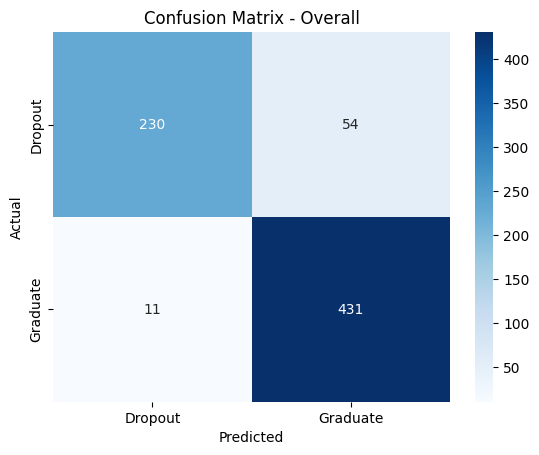

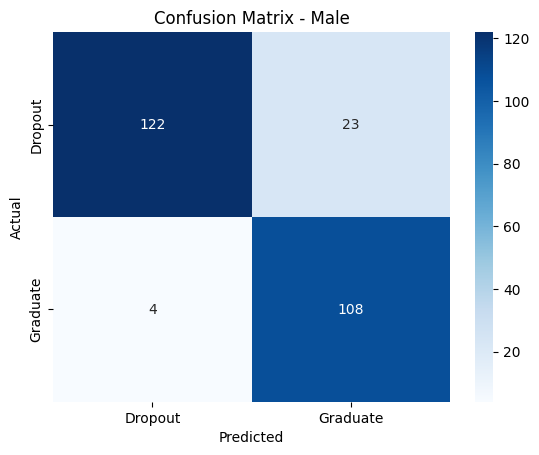

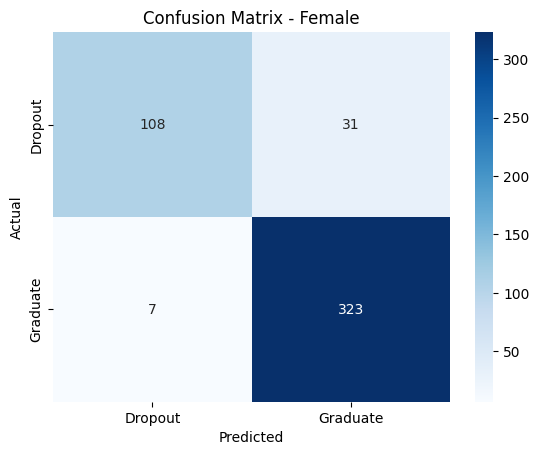

In [5]:
# Confusion matrix for all students
cm_all = confusion_matrix(y_test, y_pred)
sns.heatmap(cm_all, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Dropout', 'Graduate'],
            yticklabels=['Dropout', 'Graduate'])
plt.title('Confusion Matrix - Overall')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Confusion matrix for male students
filter_male = gender_test == 1
cm_male = confusion_matrix(y_test[filter_male], y_pred[filter_male])
sns.heatmap(cm_male, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Dropout', 'Graduate'],
            yticklabels=['Dropout', 'Graduate'])
plt.title('Confusion Matrix - Male')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Confusion matrix for female students
filter_female = gender_test == 0
cm_female = confusion_matrix(y_test[filter_female], y_pred[filter_female])
sns.heatmap(cm_female, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Dropout', 'Graduate'],
            yticklabels=['Dropout', 'Graduate'])
plt.title('Confusion Matrix - Female')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

---

### Accuracy Calculation Exercise

Based on the confusion matrices, try to manually calculate the **overall accuracy** and **accuracy per gender**. After you are done run the code below to compare your results with the printed values.

---

In [6]:
# Compute accuracy
acc_overall = accuracy_score(y_test, y_pred)
acc_male = accuracy_score(y_test[filter_male], y_pred[filter_male])
acc_female = accuracy_score(y_test[filter_female], y_pred[filter_female])

---

### Solution Accuracy Calculation

---

In [7]:
print('Overall Accuracy:', acc_overall)
print('Accuracy Male:' , acc_male)
print('Accuracy Female:' , acc_female)

Overall Accuracy: 0.9104683195592287
Accuracy Male: 0.8949416342412452
Accuracy Female: 0.9189765458422174


---

### Core Statistical Measures

Please calculate the following metrics based on the confusion matrices. 

**False Positive Rate (FPR)**, **False Negative Rate (FNR)** & **Positive Predictive Value (PPV)** 

Do this: For the **entire dataset** & separately for **male** and **female** students.
Once you are done, compare your results with the summary table below. 

---

In [8]:
# Compute core statistical measures
def core_metrics(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return {
        'TPR': tp / (tp + fn),
        'FPR': fp / (fp + tn),
        'TNR': tn / (fp + tn),
        'FNR': fn / (tp + fn),
        'PPV': tp / (tp + fp),
        'NPV': tn / (tn + fn),
        'FDR': fp / (tp + fp),
        'FOR': fn / (tn + fn)
    }

metrics_all = core_metrics(y_test, y_pred)
metrics_male = core_metrics(y_test[filter_male], y_pred[filter_male])
metrics_female = core_metrics(y_test[filter_female], y_pred[filter_female])

---

### Summary Table: Core Statistical Measures

---

In [9]:
# Measures into DataFrame
df_measures = pd.DataFrame(
    [metrics_all, metrics_male, metrics_female],
    index=['Total', 'Male', 'Female']
).round(3)

display(df_measures)

,TPR,FPR,TNR,FNR,PPV,NPV,FDR,FOR
Total,0.975,0.190,0.810,0.025,0.889,0.954,0.111,0.046
Male,0.964,0.159,0.841,0.036,0.824,0.968,0.176,0.032
Female,0.979,0.223,0.777,0.021,0.912,0.939,0.088,0.061


---

### Fairness Metrics

We will now compute the 6 observational fairness measures and discuss the results.

### Statistical (Demographic) Parity<sup>4</sup>
**Goal:** The model should assign positive predictions ($\hat{Y} = 1$) equally often to both groups. We calculate the difference in positive prediction rates between male and female students:
$$
\text{Statistical Parity Difference} = P(\hat{Y}=1 \mid \text{Male}) - P(\hat{Y}=1 \mid \text{Female})
$$
The closer this value is to **0**, the more statistically fair the model is in terms of group treatment.

You can compute **Statistical Parity** manually using the group-specific confusion matrices.

Remember:  
The number of **positive predictions** in a group equals the sum of **True Positives (TP)** and **False Positives (FP)**.

So for each group:

$$
P(\hat{Y}=1 \mid \text{Group}) = \frac{TP + FP}{TP + FP + TN + FN}
$$

Now use the confusion matrices from earlier and calculate statistical parity manually. Once you are done you can run the code below to check your results. 

---

In [10]:
# Ground truth + predictions per group
y_true_m = y_test[filter_male]
y_pred_m = y_pred[filter_male]

y_true_f = y_test[filter_female]
y_pred_f = y_pred[filter_female]

# Compute statistical parity
def compute_statistical_parity(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    total = tp + fp + tn + fn
    return (tp + fp) / total


sp_male = compute_statistical_parity(y_true_m, y_pred_m)
sp_female = compute_statistical_parity(y_true_f, y_pred_f)
sp_diff = sp_male - sp_female

print('Proportion of positive predictions for males:', sp_male)
print('Proportion of positive predictions for females:', sp_female)
print('Statistical Parity Difference:', sp_diff)

Proportion of positive predictions for males: 0.5097276264591439
Proportion of positive predictions for females: 0.7547974413646056
Statistical Parity Difference: -0.24506981490546165


---

### Interpretation

- **Statistical parity** is violated.
- Female students are **more likely** to receive a positive prediction (`Graduate`) than male students.
- The model assigns **opportunities unequally across groups**, even if those predictions are correct.

**Context matters:**  
In this scenario, a positive prediction does **not** lead to a benefit, but **excludes** students from support programs.  
Therefore, male students might actually receive **more interventions** due to the model's behavior — the fairness impact depends on **how the prediction is used**.

**Also note:**  
- The **actual base rates** for graduation **differ significantly** between groups — female students do graduate more often in the data.
- This makes it **difficult** to satisfy statistical parity without distorting reality.

Fairness metrics like Statistical Parity must therefore be interpreted **carefully** and **in context**.

---

> **Note: How to interpret fairness metric differences**
>
> There is **no universally accepted threshold** that determines when a fairness metric is considered "violated". The values below are **rule-of-thumb** guidelines that can be found in some toolkits and papers:<sup>4</sup>
>
> - **|Difference| < 0.01** → practically identical
> - **0.01 ≤ |Difference| < 0.05** → small difference, often acceptable
> - **0.05 ≤ |Difference| < 0.1** → moderate disparity, may require justification
> - **|Difference| ≥ 0.1** → strong disparity, often considered unfair
>
> These guidelines are not strict rules. Whether a difference is acceptable depends on:
> - **Context of the decision** (e.g. education, finance, healthcare)
> - **Scale and consequences** (e.g. minor errors vs. systemic harm)
> - **Baseline risks** (e.g. FNR of 0.02 vs 0.2)
>
> Even small disparities can become **ethically or legally significant** when they reinforce historical disadvantages or affect critical outcomes. Always interpret metric differences **in context** rather than relying purely on numerical thresholds.
>
> For the following analysis, a threshold of 0.05 is used to flag fairness issues, following the paper by Verma & Rubin (2018).

---

### Equal Opportunity<sup>4</sup>

**Goal:** The model should detect actual positive cases (graduates) equally well for both groups.

This means the **False Negative Rate (FNR)** should be equal across groups:

$$
\text{Equal Opportunity Difference} = \text{FNR}_{\text{Male}} - \text{FNR}_{\text{Female}}
$$

The closer this value is to **0**, the more fair the model is in terms of *equal opportunity to be correctly identified as positive*. A classifier with equal FNR will mathematically also have equal TPR (since $ \text{TPR} = 1 - \text{FNR} $).

From the summary table:
- FNR (Male): 0.036  
- FNR (Female): 0.021  
→ Difference: **0.015**

False negatives occur slightly more often for male students.  
The **difference of 0.015** is **very small** and may be considered **acceptable** under common fairness thresholds (e.g. ±0.05).  
However, even small disparities can be relevant depending on the context and scale of decisions.

---

### Predictive Equality<sup>4</sup>

**Goal:** The model should produce false positives equally often across groups.  
This is measured using the **False Positive Rate (FPR)**:

$$
\text{Predictive Equality Difference} = \text{FPR}_{\text{Male}} - \text{FPR}_{\text{Female}}
$$

From the summary table:
- FPR (Male): 0.159  
- FPR (Female): 0.223  
→ Difference: **–0.064**
 
False positives are **more frequent among female students**.  
This violates Predictive Equality, since **the model incorrectly predicts Graduate more often for women**.

---

### Equalized Odds<sup>4</sup>

**Goal:** The model should make both types of errors — false positives and false negatives — **at the same rate across groups**.

We compute:

$$
|\text{FNR}_{\text{Male}} - \text{FNR}_{\text{Female}}| + |\text{FPR}_{\text{Male}} - \text{FPR}_{\text{Female}}| = |0.036 - 0.021| + |0.159 - 0.223| = 0.015 + 0.064 = 0.079
$$

  
The model shows a **moderate violation of Equalized Odds**.  
Although FNR is relatively balanced, the **unequal false positive rates** are the main driver of this fairness gap.

---

### Predictive Parity<sup>4</sup>

**Goal:** Among those predicted to graduate ($\hat{Y} = 1$), the probability of actually graduating should be the same across groups.

This is measured by comparing the **Positive Predictive Value (PPV)**:

$$
\text{Predictive Parity Difference} = \text{PPV}_{\text{Male}} - \text{PPV}_{\text{Female}}
$$

From the summary table:
- PPV (Male): 0.824  
- PPV (Female): 0.912  
→ Difference: **–0.088**

  
The model’s **positive predictions are more reliable for female students**.  
In other words, when the model predicts graduation, it is more often correct for women than for men.

This violates **Predictive Parity** because positive predictions are **not equally trustworthy** across groups.

---

### Group Calibration<sup>4</sup>

**Goal:** The predicted probability of graduation should have the **same meaning** for each group.

That means: for a given predicted score $s$, the probability of actual graduation should be the same regardless of group membership:

$$
P(Y = 1 \mid \hat{S} = s, \text{Group} = \text{Male}) = P(Y = 1 \mid \hat{S} = s, \text{Group} = \text{Female})
$$

> $\hat{S}$ represents the predicted score (graduation probability) output by the model.
> $s$ is a specific realization of this score for an individual.

This is known as **Group Calibration** or **Test Fairness**.

**Fairness Metric**:

$$
\text{Group Calibration Difference} = \text{Average}_{s}\left|P(Y=1 \mid \hat{S}=s, \text{Male}) - P(Y=1 \mid \hat{S}=s, \text{Female})\right|
$$

The closer this value is to **0**, the better the model is calibrated across groups.

**Example**:
> Imagine two students – one male, one female – both receive a predicted graduation probability of **0.8**. **Group Calibration** means that for both groups, about **80% of students** with a predicted **score of 0.8** actually graduate.
>
> If, however:
>- only **60% of men** with score 0.8 graduate,
>- but **90% of women** with the same score do,
>
>then the model is **not calibrated across groups**. It **overestimates success for men** and **underestimates it for women**.

---

### Related Concepts

- **Calibration**:  
  $$
  P(Y = 1 \mid \hat{S} = s) = s
  $$  
  → The predicted score reflects the actual success probability *on average*, across the whole population.

- **Well-Calibration**:  
  $$
  P(Y = 1 \mid \hat{S} = s, \text{Group} = \text{Male}) = P(Y = 1 \mid \hat{S} = s, \text{Group} = \text{Female}) = s
  $$  
  → The strongest form: the predicted score equals the actual success rate and is consistent across all groups.

In fairness assessments, **group calibration** is most relevant.  
It tells us whether predicted probabilities can be interpreted **consistently and fairly** across different groups.

To better understand the differences between the types of calibration, the following section explains their calculation with an example.

---

### How to compute group calibration<sup>4</sup>

1. **Bin the predicted scores** into intervals (e.g. 0.0–0.1, 0.1–0.2, ..., 0.9–1.0)
2. For each **group** and each **bin**:
   - Compute the **mean predicted probability**
   - Compute the **actual proportion of graduates (Y = 1)**

If the observed graduation rate differs across groups for the same predicted score, **group calibration is violated**.

---

### Example: What Calibration Means in Practice

Let's look at a small group of 10 students – each with a predicted probability and actual graduation outcome:

| Student | Gender | Predicted Probability | Actual Outcome |
|---------|--------|------------------------|----------------|
| A       | Male   | 0.8                    | 0              |
| B       | Male   | 0.8                    | 1              |
| C       | Male   | 0.8                    | 0              |
| D       | Female | 0.8                    | 1              |
| E       | Female | 0.8                    | 1              |
| F       | Female | 0.8                    | 1              |
| G       | Male   | 0.4                    | 0              |
| H       | Female | 0.4                    | 1              |
| I       | Female | 0.4                    | 0              |
| J       | Male   | 0.4                    | 1              |

#### Calibration (overall)

Calibration means that across **all students**, the predicted probabilities match the actual outcomes.

- For all students with a score of 0.8 (Bin 0.8):
  - 4 out of 6 students actually graduate → 67% success rate.
- For all students with a score of 0.4 (Bin 0.4):
  - 2 out of 4 students actually graduate → 50% success rate.

**Interpretation:**  
- A score of 0.8 should ideally correspond to an 80% graduation probability.
- Here, it corresponds to 67% → the model is **not calibrated** overall.

#### Group Calibration

Group Calibration requires that predicted scores have **the same meaning** across groups.

- Among students with score 0.8:
  - **Males:** 1/3 graduated → 33%
  - **Females:** 3/3 graduated → 100%

- Among students with score 0.4:
  - **Males:** 1/2 graduated → 50%
  - **Females:** 1/2 graduated → 50%

**Interpretation:**  
- At 0.8 there is a **large difference** between males and females.
- At 0.4 no group difference appears.
- **However:**  
  → **Group Calibration evaluates the overall behavior across all scores.**  
  → Because there is a strong mismatch at 0.8, the model is **not group-calibrated**.

#### Well-Calibration

Well-Calibration is the strictest requirement:  
The predicted score must match the actual probability **for each group separately**.

- Males, score 0.8 → predicted 80%, actual 33%
- Females, score 0.8 → predicted 80%, actual 100%
- Males, score 0.4 → predicted 40%, actual 50%
- Females, score 0.4 → predicted 40%, actual 50%

**Interpretation:**  
The model is **not well-calibrated**, because neither group matches the predicted scores exactly.

---

### Group Calibration Analysis 

Now let's return to our student dropout prediction model and calculate **group calibration** based on the predicted probabilities.

---

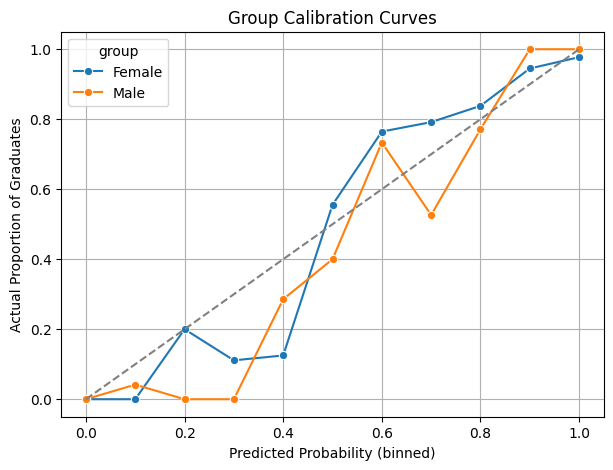

Group Calibration Difference: 0.101


In [11]:
# Create DataFrame with probabilites, true values and group membership
df_calib = pd.DataFrame({
    'prob': y_prob,
    'true': y_test,
    'group': gender_test
})

df_calib['group'] = df_calib['group'].map({0: 'Female', 1: 'Male'}) # Mapping back to names for visualization

# Bin predicted probabilities into intervals
df_calib['bin'] = (df_calib['prob'] * 10).round(0) / 10

# Compute average observed outcomes per bin and group
grouped = df_calib.groupby(['group', 'bin'])['true'].mean().reset_index()

# Visualization
plt.figure(figsize=(7,5))
sns.lineplot(data=grouped, x='bin', y='true', hue='group', marker='o')
plt.plot([0,1], [0,1], linestyle='--', color='gray') # perfect calibration line
plt.title('Group Calibration Curves')
plt.xlabel('Predicted Probability (binned)')
plt.ylabel('Actual Proportion of Graduates')
plt.grid(True)
plt.show()

# Separate male and female graduation rates by bin
calib_male = grouped[grouped['group'] == 'Male'].set_index('bin')['true']
calib_female = grouped[grouped['group'] == 'Female'].set_index('bin')['true']

# Find bins that exist for both groups
same_bins = calib_male.index.intersection(calib_female.index)

# Compute mean absolute difference across common bins
group_calibration_diff = (calib_male[same_bins] - calib_female[same_bins]).abs().mean()

print('Group Calibration Difference:', round(group_calibration_diff, 3))

---

Each curve shows the **actual graduation rate** in each score bin, **separately for male and female students**.

- A perfectly calibrated model would lie on the **gray diagonal line**
- Large deviations from this line → the model **over- or underestimates** the true graduation probability
- If the **curves for different groups diverge** → the same predicted score corresponds to **different actual outcomes** across groups

In our case, we observe:

- Systematic differences between the male and female curves
- A **mean absolute difference** in calibration of approximately **0.101**

> **Note:**
> Since we group predicted probabilities into bins, group calibration is only **approximated**. The finer the binning, the more precise the estimate. In practice, binning is necessary to make calibration measurable.

**Conclusion:**  
The model is **not group-calibrated**.  
The same predicted probability **does not mean the same thing** for all students – violating a key fairness criterion.

---

### Summary of Fairness Metrics

Below is a brief overview of how the model performs with respect to six key fairness metrics:

| Fairness Metric         | Description    | Absolute Difference                     | Fair?     |
|-------------------------|--------------------------------|----------------------------|-----------|
| **Statistical Parity**  | Equal share of positive predictions across groups   | **0.245**| Violated  |
| **Equal Opportunity**   | Equal False Negative Rate (FNR) across groups       | **0.015**| Satisfied |
| **Predictive Equality** | Equal False Positive Rate (FPR) across groups       | **0.064**| Violated  |
| **Equalized Odds**      | Both FNR and FPR are equal across groups            | **0.079**| Violated  |
| **Predictive Parity**   | Equal Positive Predictive Value (PPV) across groups | **0.088**| Violated  |
| **Group Calibration**   | Predicted scores have same meaning across groups    | **0.101**| Violated  |

---

### Interpretation

- Only **Equal Opportunity** is approximately satisfied — the model detects actual graduates equally well in both groups.
- All other metrics show violations, especially **Statistical Parity** and **Group Calibration**.
- This illustrates that **not all fairness criteria can be satisfied at the same time** and that model evaluation must be context-aware.

**Fairness metrics are diagnostic tools — not moral judgments.**  
They reveal **patterns** in model behavior, but **only a contextual interpretation** tells us whether those patterns are **unfair**.

For example, if we only looked at **Equal Opportunity**, we might conclude the model is fair.  
But a deeper look shows that **positive predictions are not equally meaningful** for male and female students, and that **opportunities are distributed unevenly**.

Fairness assessments must therefore go beyond numbers and ask:  
**What does this prediction mean — and for whom?**

In the next section, we will explore how to mitigate such fairness violations using **threshold adjustments**.

---

### Threshold Adjustment to Enforce Equalized Odds

Now that we have diagnosed fairness violations, we apply the `ThresholdOptimizer` from Fairlearn<sup>5</sup> to mitigate them.

Our goal is to enforce **Equalized Odds**:
- Equal **False Positive Rates (FPR)** across groups
- Equal **False Negative Rates (FNR)** across groups

This is done via **post-processing** – without changing the underlying model – by adjusting decision thresholds *per group* based on fairness constraints.

---

In [19]:
# Function to compute metrics based on core statistical measures
def compute_fairness(y_true, y_pred, group):
    metrics_male = core_metrics(y_true[group == 1], y_pred[group == 1])
    metrics_female = core_metrics(y_true[group == 0], y_pred[group == 0])

    return {
        'Equalized Odds': abs(metrics_male['TPR'] - metrics_female['TPR']) + abs(metrics_male['FPR'] - metrics_female['FPR']),
        'Equal Opportunity': abs(metrics_male['TPR'] - metrics_female['TPR']),
        'Predictive Equality': abs(metrics_male['FPR'] - metrics_female['FPR']),
        'Predictive Parity': abs(metrics_male['PPV'] - metrics_female['PPV'])
    }

# ThresholdOptimizer
threshopt = ThresholdOptimizer(
            estimator=model,
            constraints='equalized_odds',
            predict_method='predict_proba',
            prefit=True)

threshopt.fit(X_test, y_test, sensitive_features=gender_test)
y_pred_adj = threshopt.predict(X_test, sensitive_features=gender_test)

# Compute Fairness Metrics
fairness_scores_adj = compute_fairness(y_test, y_pred_adj, gender_test)

# Statistical Parity
# Adjusted predictions per group
y_pred_adj_m = y_pred_adj[filter_male]
y_pred_adj_f = y_pred_adj[filter_female]

# Compute statistical parity with function and ground truth values from before
sp_male_adj = compute_statistical_parity(y_true_m, y_pred_adj_m)
sp_female_adj = compute_statistical_parity(y_true_f, y_pred_adj_f)
sp_diff_adj = sp_male_adj - sp_female_adj

# Accuracy
acc_overall_adj = accuracy_score(y_test, y_pred_adj)
acc_male_adj = accuracy_score(y_test[filter_male], y_pred_adj[filter_male])
acc_female_adj = accuracy_score(y_test[filter_female], y_pred_adj[filter_female])

# Output results
print('Fairness Metrics after ThresholdOptimizer:')
print('Statistical Parity Difference:', round(sp_diff_adj, 3))
print('Equal Opportunity:', round(fairness_scores_adj['Equal Opportunity'], 3))
print('Predictive Equality:', round(fairness_scores_adj['Predictive Equality'], 3))
print('Equalized Odds:', round(fairness_scores_adj['Equalized Odds'], 3))
print('Predictive Parity:', round(fairness_scores_adj['Predictive Parity'], 3))
print('Overall Accuracy:', round(acc_overall_adj, 3))
print('Accuracy Male:', round(acc_male_adj, 3))
print('Accuracy Female:', round(acc_female_adj, 3))

Fairness Metrics after ThresholdOptimizer:
Statistical Parity Difference: -0.201
Equal Opportunity: 0.003
Predictive Equality: 0.005
Equalized Odds: 0.008
Predictive Parity: 0.142
Overall Accuracy: 0.905
Accuracy Male: 0.868
Accuracy Female: 0.925


---

### Summary of Fairness Metrics *after* Threshold Adjustment

| Fairness Metric         | Abs. Diff. before Treshold Adjustment                                                                 | Abs. Diff. after Treshold Adjustment                    | Fair?     |
|-------------------------|-----------------------------------------------------------------------------|----------------------------|-----------|
| **Statistical Parity**  | **0.245**  | **0.201** | Violated |
| **Equal Opportunity**   | **0.015**  | **0.003** | Satisfied|
| **Predictive Equality** | **0.064**  | **0.005** | Satisfied|
| **Equalized Odds**      | **0.079**  | **0.008** | Satisfied|
| **Predictive Parity**   | **0.088**  | **0.142** | Violated |
| **Group Calibration**   | **0.101**  | **-** | Violated |

> Note: The results of the ThresholdOptimizer may vary slightly each time you run this code, even with a fixed model. You will not get the exact same values, but the storyline stays the same.

---

### Why Group Calibration Cannot Be Recomputed After Threshold Adjustment<sup>6</sup>

>The `ThresholdOptimizer` does **not** change the model’s predicted probabilities — it only applies **different classification thresholds** for each group to satisfy fairness constraints like Equalized Odds.
As a result:
> - The original predicted scores (`y_prob`) no longer reflect the model’s actual behavior.
> - The adjusted predictions (`y_pred_adj`) are binary outcomes, not probabilities.
> - Calibration compares **probabilities** with **actual outcomes** — but after threshold adjustment, the *same score* can lead to *different decisions* depending on group membership.
>
> **Group Calibration is not recomputed**, as the necessary input (group-consistent scores) is no longer valid.

---

### Interpretation

After applying the `ThresholdOptimizer`, we observe:

- **Separation-based metrics** (Equal Opportunity, Predictive Equality, Equalized Odds) are now satisfied - the model treats both groups similarly in terms of error rates.
- **Statistical Parity** remains violated — male and female students still receive positive predictions at different rates.
- **Predictive Parity** worsens — positive predictions are less equally reliable across groups.
- **Group Calibration** is no longer meaningful to evaluate.

This illustrates a **key finding** in fairness research:

> **It is mathematically impossible to satisfy both Equalized Odds and Calibration when base rates differ.<sup>2,</sup><sup>3</sup>**

Optimizing one fairness metric **necessarily introduces trade-offs** in others.

In this case, we prioritized **equal error rates** — which improved separation metrics, but sacrificed **score reliability** (Calibration, Predictive Parity).

---

### Final Takeaway

**Fairness is not something that can be "fixed" through technical adjustments alone.**
The same model may appear *fair* under one metric — and *unfair* under another.

In this section, we demonstrated how a model predicting student graduation can be adjusted to satisfy **Equalized Odds** by applying **different thresholds** for male and female students.

This decision improves **error rate parity**:
- **False negatives**, which represent students wrongly assumed to succeed, are now equally distributed — an ethically desirable outcome in our case.

**Why this matters:**  
The goal is to **identify students at risk of dropping out** in order to offer support.  
Failing to identify a student at risk (false negative) may result in **denied help**, while wrongly identifying someone (false positive) may *only* result in **unnecessary support**.

In this context, a **false negative** is more harmful than a false positive.
Because of that, **Equal Opportunity** — ensuring equal False Negative Rates across groups — can be seen as the most relevant fairness criterion in this study.

>**Note:**
>From a purely technical perspective, applying the `ThresholdOptimizer` was not necessary — the model already showed **low and balanced false negative rates** between genders.
>The optimizer was used as an educational tool to:
>- Introduce the idea of fairness **interventions**
>- Highlight the **incompatibility** between different fairness metrics (e.g. Separation vs. Sufficiency)
>- Show that such interventions can have **unintended consequences**

Although the separation-based metrics improved, the intervention **worsened calibration and predictive parity** (scores are less reliable).
Additionally, the **accuracy** slightly shifted — it increased for female students and decreased for male students.
This underlines that **fairness interventions are not neutral**, they reallocate performance and create new trade-offs.

> We accept unequal treatment in scoring to achieve **more equal treatment in access to opportunity**.


**Fairness is not a number and fairness metrics are not moral truths — they are diagnostic tools for reflection.**

Each metric captures a different notion of fairness.  
No model will ever be fair by all definitions at once.

What matters is asking:
- *What is the real-world impact of this model?*
- *Whose outcomes are improved or harmed?*
- *What fairness goal are important in this context?*

Next, we take a closer look at different forms of bias that can be relevant in machine learning systems. Knowing these bias types helps explain why fairness violations arise and how they can be addressed.

---

### Quiz

**1. True or False:**
Applying group-specific thresholds to enforce Equalized Odds can cause the same predicted score to lead to different decisions for different groups.
1. [ ] True
2. [ ] False

**2. Why might it be ethically justified to accept group-specific thresholds in the student support example?**
*(Select one option)*

1. [ ] Because accuracy improves significantly for both groups
2. [ ] Because it ensures both groups have equal predicted scores
3. [ ] Because it equalizes access to support by reducing false negatives
4. [ ] Because statistical parity is the most important fairness criterion

**3. What does this notebook illustrate about fairness in machine learning?**
*(Select one option)*

1. [ ] All fairness metrics should be optimized simultaneously to ensure equity
2. [ ] Fairness is primarily a technical problem that can be solved with enough optimization
3. [ ] Different fairness metrics reflect different values and may conflict with one another
4. [ ] Applying post-processing methods like threshold adjustment guarantees fairness

---

#### Sources:
1. Realinho et al., 2021
2. Chouldechova, 2017
3. Kleinberg et al., 2016
4. Verma & Rubin, 2018
5. Fairlearn Organization, n.d.
6. Pleiss et al., 2017